<a href="https://colab.research.google.com/github/Sam74012/Disease_detection_model/blob/main/Disease_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/Datasets/balanced_disease_dataset.zip" -d "/content/disease_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/disease_dataset/balanced_dataset/train/Rice__Sheath_Blight/aug_0_8907.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 34.05 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [ ]:
from helper_functions import walk_through_dir
walk_through_dir("disease_dataset/balanced_dataset")

There are 3 directories and 0 images in 'disease_dataset/balanced_dataset'.
There are 17 directories and 0 images in 'disease_dataset/balanced_dataset/val'.
There are 0 directories and 62 images in 'disease_dataset/balanced_dataset/val/Rice__Sheath_Blight'.
There are 0 directories and 62 images in 'disease_dataset/balanced_dataset/val/Rice__Brown_Spot'.
There are 0 directories and 62 images in 'disease_dataset/balanced_dataset/val/Wheat___Brown_Rust'.
There are 0 directories and 62 images in 'disease_dataset/balanced_dataset/val/Corn___Healthy'.
There are 0 directories and 62 images in 'disease_dataset/balanced_dataset/val/Cotton__Fussarium_Wilt'.
There are 0 directories and 62 images in 'disease_dataset/balanced_dataset/val/Wheat___Healthy'.
There are 0 directories and 62 images in 'disease_dataset/balanced_dataset/val/Wheat___Yellow_Rust'.
There are 0 directories and 62 images in 'disease_dataset/balanced_dataset/val/Rice__Leaf_Scald'.
There are 0 directories and 62 images in 'diseas

In [ ]:
from pathlib import Path
data_path=Path("disease_dataset/balanced_dataset")
train_dir=data_path / "train"
test_dir=data_path / "test"
val_dir=data_path / "val"
train_dir, test_dir, val_dir

(PosixPath('disease_dataset/balanced_dataset/train'),
 PosixPath('disease_dataset/balanced_dataset/test'),
 PosixPath('disease_dataset/balanced_dataset/val'))

In [ ]:
import os
from PIL import Image

dataset_root = train_dir

for root_dir, dirs, files in os.walk(dataset_root):
    for file in files:
        if file.lower().endswith(".gif"):
            gif_path = os.path.join(root_dir, file)
            png_path = os.path.join(root_dir, file.rsplit('.', 1)[0] + ".png")

            # Convert GIF to PNG
            with Image.open(gif_path) as im:
                im.convert('RGB').save(png_path)

            # Delete the original GIF
            os.remove(gif_path)

            print(f"Converted and removed: {gif_path} -> {png_path}")

print("All GIFs have been converted to PNGs and removed.")


Converted and removed: disease_dataset/balanced_dataset/train/Cotton__Curl_Virus/curl314.gif -> disease_dataset/balanced_dataset/train/Cotton__Curl_Virus/curl314.png
All GIFs have been converted to PNGs and removed.


In [ ]:
import os

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS=os.cpu_count()

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),  # 256 for 224
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)
test_ds = datasets.ImageFolder(test_dir, transform=val_tfms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_dl=DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
len(train_dl), len(test_dl), len(val_dl)

(156, 34, 33)

In [ ]:
train_ds

Dataset ImageFolder
    Number of datapoints: 4964
    Root location: disease_dataset/balanced_dataset/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_ds.class_to_idx

{'Corn___Common_Rust': 0,
 'Corn___Gray_Leaf_Spot': 1,
 'Corn___Healthy': 2,
 'Corn___Northern_Leaf_Blight': 3,
 'Cotton__Bacterial_Blight': 4,
 'Cotton__Curl_Virus': 5,
 'Cotton__Fussarium_Wilt': 6,
 'Cotton__Healthy': 7,
 'Rice__Bacterial_Leaf_Blight': 8,
 'Rice__Brown_Spot': 9,
 'Rice__Healthy': 10,
 'Rice__Leaf_Blast': 11,
 'Rice__Leaf_Scald': 12,
 'Rice__Sheath_Blight': 13,
 'Wheat___Brown_Rust': 14,
 'Wheat___Healthy': 15,
 'Wheat___Yellow_Rust': 16}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model =  models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT).to(device)
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 44.5MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 112

In [ ]:
for p in model.features.parameters():
  p.requires_grad=False

for p in model.features[-2:].parameters():
  p.requires_grad=True

num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 17)

In [ ]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 17]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   (432)                False
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   (32)                 False
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW([
    {'params': model.features[-2].parameters(), 'lr': 1e-5},
    {'params': model.features[-1].parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 3e-4}
],
                              weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/CheckpointsforDeseaseModel"
os.makedirs(checkpoint_dir, exist_ok=True)
last_path=os.path.join(checkpoint_dir, "last.pth")
best_path=os.path.join(checkpoint_dir, "best.pth")
last_path, best_path

('/content/drive/MyDrive/CheckpointsforDeseaseModel/last.pth',
 '/content/drive/MyDrive/CheckpointsforDeseaseModel/best.pth')

In [ ]:
def load_existing_best(best_path, device=device):
    """Returns val_acc in existing best.pth or 0.0 if none."""
    if os.path.exists(best_path):
        ckpt = torch.load(best_path, map_location=device)
        return ckpt.get("val_acc", [0.0])[-1]
    return 0.0


def save_checkpoint(model, optimizer, scheduler, epoch, results, last_path=last_path, best_path=best_path):
    """
    • ALWAYS overwrites last.pth
    • Only overwrites best.pth if val_acc is better than what's inside best.pth
    """
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "train_loss": results["train_loss"],
        "val_loss": results["val_loss"],
        "train_acc": results["train_acc"],
        "val_acc": results["val_acc"]
    }

    # --- Save last ---
    torch.save(state, last_path)
    print(f"✅ Saved LAST checkpoint → {last_path}")

    # --- Save best (persistent) ---
    best_val = load_existing_best(best_path)
    if results["val_acc"][-1] > best_val:
        torch.save(state, best_path)
        print(f"⭐ New ALL-TIME BEST (val_acc={results['val_acc'][-1]:.4f}) → {best_path}")

In [ ]:
def load_checkpoint(model, optimizer, scheduler, fine_tune=False,
                    last_path=last_path, best_path=best_path, device=device):
    """
    Loads either:
      • last checkpoint (resume training)
      • best checkpoint (fine-tune)
    Returns:
      start_epoch (int), results (dict)
    """
    if fine_tune:
        if not (best_path and os.path.exists(best_path)):
            print("⚠ No best checkpoint found, starting fresh.")
            return 0, {}
        ckpt = torch.load(best_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        results = {
            "train_loss": ckpt.get("train_loss", [0.0]),
            "val_loss": ckpt.get("val_loss", [0.0]),
            "train_acc": ckpt.get("train_acc", [0.0]),
            "val_acc": ckpt.get("val_acc", [0.0])
        }
        start_epoch = ckpt.get("epoch", 0) + 1   # keep the number for reference
        print(f"Loaded BEST checkpoint (epoch {ckpt.get('epoch', 0)}, "
              f"val_acc={ckpt.get('val_acc', [0.0])[-1]:.4f}) for fine-tuning.")
    else:
        if not (last_path and os.path.exists(last_path)):
            print("⚠ No last checkpoint found, starting fresh.")
            return 0, {}
        ckpt = torch.load(last_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        scheduler.load_state_dict(ckpt["scheduler_state"])
        results = {
            "train_loss": ckpt.get("train_loss", [0.0]),
            "val_loss": ckpt.get("val_loss", [0.0]),
            "train_acc": ckpt.get("train_acc", [0.0]),
            "val_acc": ckpt.get("val_acc", [0.0])
        }
        start_epoch = ckpt["epoch"] + 1
        print(f"Resumed from LAST checkpoint (epoch {ckpt['epoch']}, "
              f"val_acc={ckpt.get('val_acc', [0.0])[-1]:.4f}).")

    return start_epoch, results

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
from going_modular import engine

start_epoch, results = load_checkpoint(
    model, optimizer, scheduler,
    fine_tune=False
)

if not results:
  results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

EPOCHS = 108   # total epochs you want overall
start_time = timer()

for epoch in tqdm(range(start_epoch, EPOCHS), desc="Epochs"):
    # ----- 1. Train -----
    train_loss, train_acc = engine.train_step(
        model, train_dl, loss_fn, optimizer, device
    )

    # ----- 2. Validate -----
    val_loss, val_acc = engine.test_step(
        model, val_dl, loss_fn, device
    )

    # ----- 3. Log -----
    print(f"Epoch {epoch+1} | "
          f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

    # ----- 4. Save Checkpoints -----
    save_checkpoint(model, optimizer, scheduler, epoch, results)

    # ----- 5. Step Scheduler -----
    scheduler.step()

end_time = timer()
print(f"[INFO] Training finished in {end_time - start_time:.2f} sec")

Resumed from LAST checkpoint (epoch 107, val_acc=0.9593).


Epochs: 0it [00:00, ?it/s]

[INFO] Training finished in 0.02 sec


In [ ]:
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
results = {
            "train_loss": ckpt.get("train_loss", [0.0]),
            "val_loss": ckpt.get("val_loss", [0.0]),
            "train_acc": ckpt.get("train_acc", [0.0]),
            "val_acc": ckpt.get("val_acc", [0.0])
        }
print(f"Val_acc: {results["val_acc"][-1]}")
print(f"Val_loss: {results["val_loss"][-1]}")

Val_acc: 0.9602272727272727
Val_loss: 0.475887937076164


In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

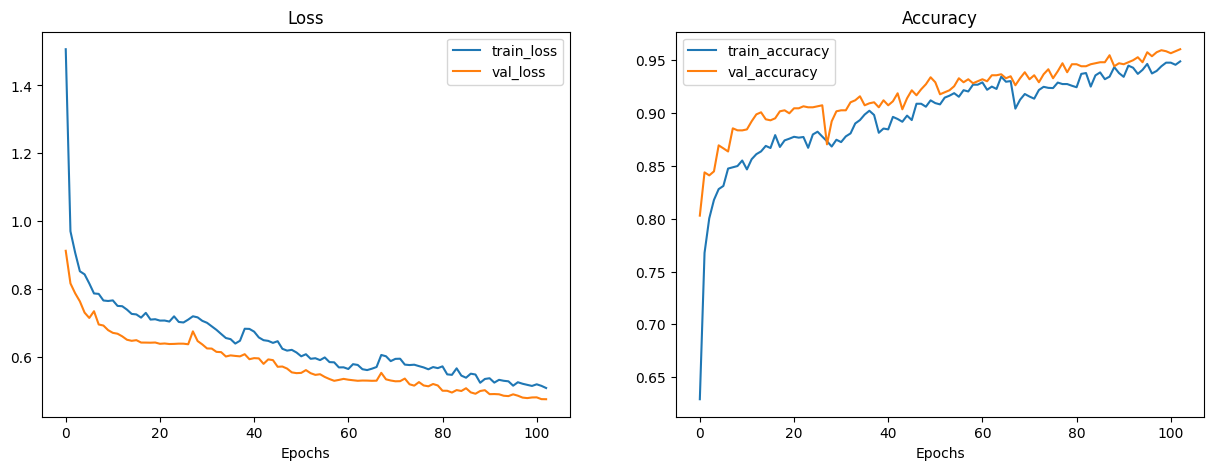

In [ ]:
plot_loss_curves(results)

In [ ]:
from tqdm.auto import tqdm
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device):
  loss, acc=0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y=X.to(device), y.to(device)
      y_pred=model(X)
      loss+=loss_fn(y_pred, y).item()
      test_pred_labels=torch.argmax(y_pred, dim=1)
      acc+=((test_pred_labels == y).sum().item()/len(test_pred_labels))

  loss/=len(data_loader)
  acc/=len(data_loader)

  return {
      "model_name": "MobilenetV3Large_Disease_Detect",
      "model_loss": loss,
      "model_acc": acc
  }

In [ ]:
test_results=eval_model(model=model,
                        data_loader=test_dl,
                        loss_fn=loss_fn,
                        device=device)
test_results

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/34 [00:00<?, ?it/s]

{'model_name': 'MobilenetV3Large_Disease_Detect',
 'model_loss': 0.468254491686821,
 'model_acc': 0.9586397058823529}

In [ ]:
from typing import List, Tuple
import requests
from io import BytesIO
from PIL import Image

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model."""

    # --- open the image ---
    try:
        if image_path.lower().startswith(("http://", "https://")):
            response = requests.get(image_path, timeout=10)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # --- set up transforms ---
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ]
        )

    # --- predict ---
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(0).to(device)
        target_image_pred = model(transformed_image)

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # --- plot ---
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | "
        f"Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)


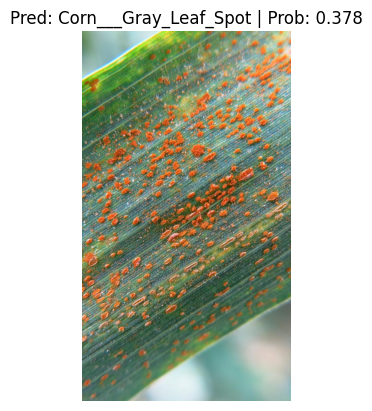

In [ ]:
pred_and_plot_image(model=model,
                    class_names=train_ds.classes,
                    image_path="https://images.ctfassets.net/l2hapltrg3cz/3WLjOsiirXcjRHpQTpCfHR/4431373a1d23fc2609ce6fbfacc8453d/brown-rust-wheat-a1-cl-lib.jpg",
                    transform=val_tfms)

In [ ]:
from typing import List, Tuple
import requests
from io import BytesIO
from PIL import Image

def pred_and_plot_image_top3(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predict on an image and show the **top-3** predictions with probs."""

    # --- open the image ---
    try:
        if image_path.lower().startswith(("http://", "https://")):
            response = requests.get(image_path, timeout=10)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")
        else:
            img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # --- set up transforms ---
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ]
        )

    # --- predict ---
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(0).to(device)
        logits = model(transformed_image)

    probs = torch.softmax(logits, dim=1).squeeze(0)      # [num_classes]
    top_probs, top_idxs = torch.topk(probs, k=3)          # top 3

    # --- build a string for plotting ---
    top_lines = [
        f"{class_names[idx]}: {prob:.2%}"
        for prob, idx in zip(top_probs, top_idxs)
    ]
    title_str = " | ".join(top_lines)

    # --- plot ---
    plt.figure()
    plt.imshow(img)
    plt.title(title_str)
    plt.axis(False)
    plt.show()

    # optionally return raw values
    return [(class_names[idx], float(prob)) for prob, idx in zip(top_probs, top_idxs)]

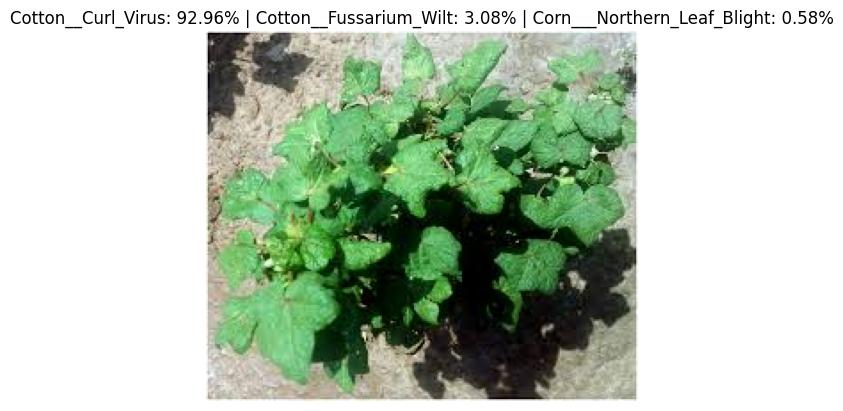

[('Cotton__Curl_Virus', 0.9295989274978638),
 ('Cotton__Fussarium_Wilt', 0.030750541016459465),
 ('Corn___Northern_Leaf_Blight', 0.005849586799740791)]

In [ ]:
pred_and_plot_image_top3(
    model=model,
    class_names=train_ds.classes,
    image_path="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQQQuXfU-rYcNyqcRr2B_EdQ4wPVwx9ibEIaw&s",
    transform=val_tfms
    )

In [ ]:
try:
  import onnx
  import torch.onnx
except:
  !pip install -q onnx
  import onnx
  import torch.onnx

model.eval()
dummy_input = torch.randn(1, 3, 224, 224)

torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    export_params=True,
    opset_version=13,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print("✅ ONNX model exported --> model.onnx")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 71.7 MB/s eta 0:00:00


/tmp/ipython-input-4245165115.py:12: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ ONNX model exported --> model.onnx
